In [829]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import requests
import scipy.stats as sps
import arviz as az

az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

sns.set()

In [830]:
start_date = '2020-03-01'
end_date = '2020-08-23'

url = 'https://covidtrackerapi.bsg.ox.ac.uk/api/v2/stringency/date-range/{}/{}'.format(start_date,end_date)

r = requests.get(url,timeout=5.0)
r.status_code

200

In [831]:
keys = pd.date_range(start_date,end_date)
keys

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10',
               ...
               '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
               '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
               '2020-08-22', '2020-08-23'],
              dtype='datetime64[ns]', length=176, freq='D')

In [832]:
json = r.json()
data = json['data']
countries = json['countries']

In [833]:
data_list = []

for k in keys:
    date = k.date().strftime('%Y-%m-%d')
    for c in countries:
        try:
            data_list.append((date,c,data[date][c]['confirmed'],data[date][c]['deaths'],data[date][c]['stringency']))
        except KeyError:
            pass

In [834]:
df = pd.DataFrame(data_list,columns=['date','country','confirmed','dead','oxford_stringency'])
df['date'] = pd.to_datetime(df['date'])
df.set_index(['country','date'],inplace=True)
df.dropna(inplace=True)

df

,,confirmed,dead,oxford_stringency
country,date,,,
AFG,2020-03-01,1.0,0.0,27.78
ARE,2020-03-01,21.0,0.0,15.74
AUS,2020-03-01,26.0,1.0,19.44
AUT,2020-03-01,10.0,0.0,11.11
AZE,2020-03-01,1.0,0.0,19.44
...,...,...,...,...
VNM,2020-08-23,1014.0,26.0,81.02
YEM,2020-08-23,1907.0,546.0,31.48
ZAF,2020-08-23,607045.0,12987.0,80.56


In [835]:
population = pd.read_csv('world_pop.csv',sep=';',thousands=',',header=None,index_col=0)
population.columns=['pop']
population.index.name='country'
population

,pop
country,
Afghanistan,38928346
Albania,2877797
Algeria,43851044
American Samoa,55191
Andorra,77265
...,...
Wallis & Futuna,11239
Western Sahara,597339
Yemen,29825964


In [836]:
three_letter_abb = pd.read_csv('three_letter_country_abb.csv',sep=';',header=None,index_col=2)
three_letter_abb = three_letter_abb[0]
three_letter_abb.loc['GBR']

'UK'

In [837]:
df = df.reset_index(level=1)

In [838]:
df = df.join(three_letter_abb)
df.rename(columns={0 : 'country'},inplace=True)
df

,date,confirmed,dead,oxford_stringency,country
ABW,2020-03-13,2.0,0.0,0.00,Aruba
ABW,2020-03-20,4.0,0.0,33.33,Aruba
ABW,2020-03-24,12.0,0.0,44.44,Aruba
ABW,2020-03-25,17.0,0.0,44.44,Aruba
ABW,2020-03-26,19.0,0.0,44.44,Aruba
...,...,...,...,...,...
ZWE,2020-08-19,5378.0,141.0,80.56,Zimbabwe
ZWE,2020-08-20,5643.0,150.0,80.56,Zimbabwe
ZWE,2020-08-21,5745.0,151.0,80.56,Zimbabwe
ZWE,2020-08-22,5815.0,152.0,80.56,Zimbabwe


In [839]:
df = df.merge(population,left_on='country',right_on=population.index)
df['dead_per_M'] = df['dead'] / (df['pop'] / 1e6)
df

,date,confirmed,dead,oxford_stringency,country,pop,dead_per_M
0,2020-03-13,2.0,0.0,0.00,Aruba,106766,0.000000
1,2020-03-20,4.0,0.0,33.33,Aruba,106766,0.000000
2,2020-03-24,12.0,0.0,44.44,Aruba,106766,0.000000
3,2020-03-25,17.0,0.0,44.44,Aruba,106766,0.000000
4,2020-03-26,19.0,0.0,44.44,Aruba,106766,0.000000
...,...,...,...,...,...,...,...
26944,2020-08-19,5378.0,141.0,80.56,Zimbabwe,14862924,9.486693
26945,2020-08-20,5643.0,150.0,80.56,Zimbabwe,14862924,10.092227
26946,2020-08-21,5745.0,151.0,80.56,Zimbabwe,14862924,10.159508
26947,2020-08-22,5815.0,152.0,80.56,Zimbabwe,14862924,10.226790


In [840]:
three_letter_abb.name='country'
three_letter_abb.index.name='abb'
three_letter_abb = pd.DataFrame(three_letter_abb)
three_letter_abb.columns=['country']
three_letter_abb.reset_index(inplace=True)

In [841]:
def standardize(series):
    return (series - series.mean()) / series.std()

In [842]:
df = df.merge(three_letter_abb,left_on='country',right_on='country')

df['dead_per_M_std'] = standardize(df['dead_per_M'])
df['ox_std'] = standardize(df['oxford_stringency'])

df.dropna(inplace=True)

mask = (df['confirmed'] > 100)
df = df[mask]

df

,date,confirmed,dead,oxford_stringency,country,pop,dead_per_M,abb,dead_per_M_std,ox_std
45,2020-05-07,101.0,2.0,81.48,Aruba,106766,18.732555,ABW,-0.250429,0.750163
46,2020-05-08,101.0,3.0,81.48,Aruba,106766,28.098833,ABW,-0.187454,0.750163
47,2020-05-09,101.0,3.0,81.48,Aruba,106766,28.098833,ABW,-0.187454,0.750163
48,2020-05-10,101.0,3.0,81.48,Aruba,106766,28.098833,ABW,-0.187454,0.750163
49,2020-05-11,101.0,3.0,81.48,Aruba,106766,28.098833,ABW,-0.187454,0.750163
...,...,...,...,...,...,...,...,...,...,...
26944,2020-08-19,5378.0,141.0,80.56,Zimbabwe,14862924,9.486693,ZWE,-0.312594,0.707782
26945,2020-08-20,5643.0,150.0,80.56,Zimbabwe,14862924,10.092227,ZWE,-0.308522,0.707782
26946,2020-08-21,5745.0,151.0,80.56,Zimbabwe,14862924,10.159508,ZWE,-0.308070,0.707782
26947,2020-08-22,5815.0,152.0,80.56,Zimbabwe,14862924,10.226790,ZWE,-0.307618,0.707782


In [843]:
swe = df.loc[df['abb'] == 'SWE']
uk = df.loc[df['abb'] == 'GBR']
us = df.loc[df['abb'] == 'USA']
bel = df.loc[df['abb'] == 'BEL']
aus = df.loc[df['abb'] == 'AUS']

In [844]:
df

,date,confirmed,dead,oxford_stringency,country,pop,dead_per_M,abb,dead_per_M_std,ox_std
45,2020-05-07,101.0,2.0,81.48,Aruba,106766,18.732555,ABW,-0.250429,0.750163
46,2020-05-08,101.0,3.0,81.48,Aruba,106766,28.098833,ABW,-0.187454,0.750163
47,2020-05-09,101.0,3.0,81.48,Aruba,106766,28.098833,ABW,-0.187454,0.750163
48,2020-05-10,101.0,3.0,81.48,Aruba,106766,28.098833,ABW,-0.187454,0.750163
49,2020-05-11,101.0,3.0,81.48,Aruba,106766,28.098833,ABW,-0.187454,0.750163
...,...,...,...,...,...,...,...,...,...,...
26944,2020-08-19,5378.0,141.0,80.56,Zimbabwe,14862924,9.486693,ZWE,-0.312594,0.707782
26945,2020-08-20,5643.0,150.0,80.56,Zimbabwe,14862924,10.092227,ZWE,-0.308522,0.707782
26946,2020-08-21,5745.0,151.0,80.56,Zimbabwe,14862924,10.159508,ZWE,-0.308070,0.707782
26947,2020-08-22,5815.0,152.0,80.56,Zimbabwe,14862924,10.226790,ZWE,-0.307618,0.707782


In [845]:

def shift_and_merge(shift=0):
    temp = pd.DataFrame()


    country_groups = df.groupby('abb')

    for country_abb in country_groups.groups.keys():
        country = country_groups.get_group(country_abb).copy()
        country['dead_inc'] = country['dead'] - country['dead'].shift()
        country['dead_per_M_inc'] = country['dead_per_M'] - country['dead_per_M'].shift()
        country['dead_per_M_inc_std'] = standardize(country['dead_per_M_inc'])
        country['dead_per_M_change']  = country['dead_per_M_inc'] - country['dead_per_M_inc'].shift()
        country['dead_per_M_change_std'] = standardize(country['dead_per_M_change'])
        country.dropna(inplace=True)
        temp = pd.concat([temp,country])
        
    return temp

In [846]:
shift = 21

all_shifted = shift_and_merge(shift=shift)

all_shifted.dropna(inplace=True)
all_shifted.reset_index(inplace=True,drop=True)

all_shifted

,date,confirmed,dead,oxford_stringency,country,pop,dead_per_M,abb,dead_per_M_std,ox_std,dead_inc,dead_per_M_inc,dead_per_M_inc_std,dead_per_M_change,dead_per_M_change_std
0,2020-05-09,101.0,3.0,81.48,Aruba,106766,28.098833,ABW,-0.187454,0.750163,0.0,0.000000,-0.224778,-9.366278e+00,-4.102845
1,2020-05-10,101.0,3.0,81.48,Aruba,106766,28.098833,ABW,-0.187454,0.750163,0.0,0.000000,-0.224778,0.000000e+00,0.000000
2,2020-05-11,101.0,3.0,81.48,Aruba,106766,28.098833,ABW,-0.187454,0.750163,0.0,0.000000,-0.224778,0.000000e+00,0.000000
3,2020-05-12,101.0,3.0,81.48,Aruba,106766,28.098833,ABW,-0.187454,0.750163,0.0,0.000000,-0.224778,0.000000e+00,0.000000
4,2020-05-13,101.0,3.0,81.48,Aruba,106766,28.098833,ABW,-0.187454,0.750163,0.0,0.000000,-0.224778,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21036,2020-08-19,5378.0,141.0,80.56,Zimbabwe,14862924,9.486693,ZWE,-0.312594,0.707782,6.0,0.403689,1.259938,2.018445e-01,0.752932
21037,2020-08-20,5643.0,150.0,80.56,Zimbabwe,14862924,10.092227,ZWE,-0.308522,0.707782,9.0,0.605534,2.141557,2.018445e-01,0.752932
21038,2020-08-21,5745.0,151.0,80.56,Zimbabwe,14862924,10.159508,ZWE,-0.308070,0.707782,1.0,0.067282,-0.209427,-5.382521e-01,-2.018561
21039,2020-08-22,5815.0,152.0,80.56,Zimbabwe,14862924,10.226790,ZWE,-0.307618,0.707782,1.0,0.067282,-0.209427,-1.776357e-15,-0.002930


In [847]:
country_idx_map = dict(zip(all_shifted['abb'].unique(),range(len(all_shifted['abb']))))

inv_map = {v: k for k, v in country_idx_map.items()}

all_shifted['country_idx'] = all_shifted['abb'].apply(lambda x : country_idx_map[x])
all_shifted

,date,confirmed,dead,oxford_stringency,country,pop,dead_per_M,abb,dead_per_M_std,ox_std,dead_inc,dead_per_M_inc,dead_per_M_inc_std,dead_per_M_change,dead_per_M_change_std,country_idx
0,2020-05-09,101.0,3.0,81.48,Aruba,106766,28.098833,ABW,-0.187454,0.750163,0.0,0.000000,-0.224778,-9.366278e+00,-4.102845,0
1,2020-05-10,101.0,3.0,81.48,Aruba,106766,28.098833,ABW,-0.187454,0.750163,0.0,0.000000,-0.224778,0.000000e+00,0.000000,0
2,2020-05-11,101.0,3.0,81.48,Aruba,106766,28.098833,ABW,-0.187454,0.750163,0.0,0.000000,-0.224778,0.000000e+00,0.000000,0
3,2020-05-12,101.0,3.0,81.48,Aruba,106766,28.098833,ABW,-0.187454,0.750163,0.0,0.000000,-0.224778,0.000000e+00,0.000000,0
4,2020-05-13,101.0,3.0,81.48,Aruba,106766,28.098833,ABW,-0.187454,0.750163,0.0,0.000000,-0.224778,0.000000e+00,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21036,2020-08-19,5378.0,141.0,80.56,Zimbabwe,14862924,9.486693,ZWE,-0.312594,0.707782,6.0,0.403689,1.259938,2.018445e-01,0.752932,151
21037,2020-08-20,5643.0,150.0,80.56,Zimbabwe,14862924,10.092227,ZWE,-0.308522,0.707782,9.0,0.605534,2.141557,2.018445e-01,0.752932,151
21038,2020-08-21,5745.0,151.0,80.56,Zimbabwe,14862924,10.159508,ZWE,-0.308070,0.707782,1.0,0.067282,-0.209427,-5.382521e-01,-2.018561,151
21039,2020-08-22,5815.0,152.0,80.56,Zimbabwe,14862924,10.226790,ZWE,-0.307618,0.707782,1.0,0.067282,-0.209427,-1.776357e-15,-0.002930,151


In [848]:
swe = all_shifted.loc[all_shifted['abb'] == 'SWE']
print (swe.max())
print (swe.min())

date                     2020-08-23 00:00:00
confirmed                              86068
dead                                    5810
oxford_stringency                       46.3
country                               Sweden
pop                                 10099265
dead_per_M                           575.289
abb                                      SWE
dead_per_M_std                       3.49161
ox_std                              -0.87045
dead_inc                                 185
dead_per_M_inc                       18.3182
dead_per_M_inc_std                   3.66445
dead_per_M_change                    14.3575
dead_per_M_change_std                4.09448
country_idx                              133
dtype: object
date                     2020-03-09 00:00:00
confirmed                                203
dead                                       0
oxford_stringency                      11.11
country                               Sweden
pop                                 10099

In [849]:
inv_map

{0: 'ABW',
 1: 'AFG',
 2: 'AGO',
 3: 'ALB',
 4: 'AND',
 5: 'ARE',
 6: 'ARG',
 7: 'AUS',
 8: 'AUT',
 9: 'AZE',
 10: 'BEL',
 11: 'BEN',
 12: 'BFA',
 13: 'BGD',
 14: 'BGR',
 15: 'BHR',
 16: 'BIH',
 17: 'BLR',
 18: 'BLZ',
 19: 'BMU',
 20: 'BOL',
 21: 'BRA',
 22: 'BRN',
 23: 'BWA',
 24: 'CAF',
 25: 'CAN',
 26: 'CHE',
 27: 'CHL',
 28: 'CHN',
 29: 'CIV',
 30: 'CMR',
 31: 'COL',
 32: 'CPV',
 33: 'CRI',
 34: 'CUB',
 35: 'CYP',
 36: 'CZE',
 37: 'DEU',
 38: 'DJI',
 39: 'DNK',
 40: 'DOM',
 41: 'DZA',
 42: 'ECU',
 43: 'EGY',
 44: 'ESP',
 45: 'EST',
 46: 'ETH',
 47: 'FIN',
 48: 'FRA',
 49: 'GAB',
 50: 'GBR',
 51: 'GEO',
 52: 'GHA',
 53: 'GIN',
 54: 'GMB',
 55: 'GRC',
 56: 'GTM',
 57: 'GUM',
 58: 'GUY',
 59: 'HKG',
 60: 'HND',
 61: 'HRV',
 62: 'HTI',
 63: 'HUN',
 64: 'IDN',
 65: 'IND',
 66: 'IRL',
 67: 'IRN',
 68: 'IRQ',
 69: 'ISL',
 70: 'ISR',
 71: 'ITA',
 72: 'JAM',
 73: 'JOR',
 74: 'JPN',
 75: 'KAZ',
 76: 'KEN',
 77: 'KGZ',
 78: 'KWT',
 79: 'LBN',
 80: 'LBR',
 81: 'LBY',
 82: 'LKA',
 83: 'LSO',
 8

In [850]:
swe = all_shifted.loc[all_shifted['abb'] == 'SWE']
per = all_shifted.loc[all_shifted['abb'] == 'PER']
swe

,date,confirmed,dead,oxford_stringency,country,pop,dead_per_M,abb,dead_per_M_std,ox_std,dead_inc,dead_per_M_inc,dead_per_M_inc_std,dead_per_M_change,dead_per_M_change_std,country_idx
18539,2020-03-09,203.0,0.0,11.11,Sweden,10099265,0.000000,SWE,-0.376378,-2.491523,0.0,0.000000,-0.836396,0.000000,-1.206150e-17,133
18540,2020-03-10,248.0,0.0,11.11,Sweden,10099265,0.000000,SWE,-0.376378,-2.491523,0.0,0.000000,-0.836396,0.000000,-1.206150e-17,133
18541,2020-03-11,326.0,0.0,11.11,Sweden,10099265,0.000000,SWE,-0.376378,-2.491523,0.0,0.000000,-0.836396,0.000000,-1.206150e-17,133
18542,2020-03-12,462.0,1.0,16.67,Sweden,10099265,0.099017,SWE,-0.375712,-2.235394,1.0,0.099017,-0.812067,0.099017,2.823778e-02,133
18543,2020-03-13,620.0,1.0,16.67,Sweden,10099265,0.099017,SWE,-0.375712,-2.235394,0.0,0.000000,-0.836396,-0.099017,-2.823778e-02,133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18702,2020-08-19,85219.0,5790.0,37.04,Sweden,10099265,573.309048,SWE,3.478300,-1.297024,3.0,0.297051,-0.763409,-0.099017,-2.823778e-02,133
18703,2020-08-20,85411.0,5802.0,37.04,Sweden,10099265,574.497253,SWE,3.486289,-1.297024,12.0,1.188205,-0.544449,0.891154,2.541400e-01,133
18704,2020-08-21,85810.0,5805.0,37.04,Sweden,10099265,574.794304,SWE,3.488286,-1.297024,3.0,0.297051,-0.763409,-0.891154,-2.541400e-01,133
18705,2020-08-22,86068.0,5810.0,37.04,Sweden,10099265,575.289390,SWE,3.491615,-1.297024,5.0,0.495086,-0.714752,0.198034,5.647555e-02,133


In [851]:
# hierarcical model

# standardized values

# MODEL
# inc_deaths_per_M ~ Normal(req,obs_sigma)
# req = alpha[country_idx] + beta[country_idx] * ox_idx
# alpha ~ Normal(alpha_bar,alpha_sd)
# alpha_bar ~ Normal(0,1)
# alpha_sd ~ Exponential(1)
# beta ~ Normal(beta_bar,beta_sd)
# beta_bar ~ Normal(0,1)
# beta_sd ~ Exponential(1)
#
x = all_shifted['ox_std'].values
country_idx = all_shifted['country_idx'].values

model = pm.Model()

summary = pd.DataFrame()
result = pd.DataFrame()

with model:
    
    obs_sigma = pm.Exponential('obs_sigma',1)

    alpha_bar = pm.Normal('alpha_bar',mu=0,sd=1)
    alpha_sd = pm.Exponential('alpha_sd',1)

    beta_bar = pm.Normal('beta_bar',mu=0,sd=1)
    beta_sd = pm.Exponential('beta_sd',1)

    alpha = pm.Normal('alpha',mu=alpha_bar,sd=alpha_sd,shape=len(country_idx_map))
    beta = pm.Normal('beta',mu=beta_bar,sd=beta_sd,shape=len(country_idx_map))

    reg = alpha[country_idx] + beta[country_idx] * x
    
    lkh = pm.Normal('lkh',mu=reg,sd=obs_sigma,observed=all_shifted['dead_per_M_inc_std'])
    
    trace = pm.sample(500,tune=500)
    
    result = pm.trace_to_dataframe(trace)
    summary = az.summary(trace)
    print (summary)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, beta_sd, beta_bar, alpha_sd, alpha_bar, obs_sigma]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 60 seconds.


            mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
alpha_bar  0.186  0.037     0.125      0.240      0.001    0.001     816.0   
beta_bar   0.098  0.063     0.002      0.197      0.002    0.001    1434.0   
alpha[0]   0.097  0.160    -0.151      0.348      0.005    0.004     973.0   
alpha[1]  -0.070  0.171    -0.352      0.193      0.006    0.006     888.0   
alpha[2]  -0.297  0.292    -0.830      0.106      0.009    0.008     953.0   
...          ...    ...       ...        ...        ...      ...       ...   
beta[150]  0.394  0.228     0.012      0.743      0.007    0.005     934.0   
beta[151]  0.753  0.322     0.311      1.347      0.010    0.007     994.0   
obs_sigma  0.927  0.005     0.919      0.934      0.000    0.000    2486.0   
alpha_sd   0.432  0.040     0.363      0.490      0.002    0.002     314.0   
beta_sd    0.717  0.052     0.636      0.795      0.002    0.001     599.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
alpha_bar   724.

/usr/local/lib/python3.8/site-packages/arviz/plots/traceplot.py:250: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (309), generating only 20 plots
  warnings.warn(


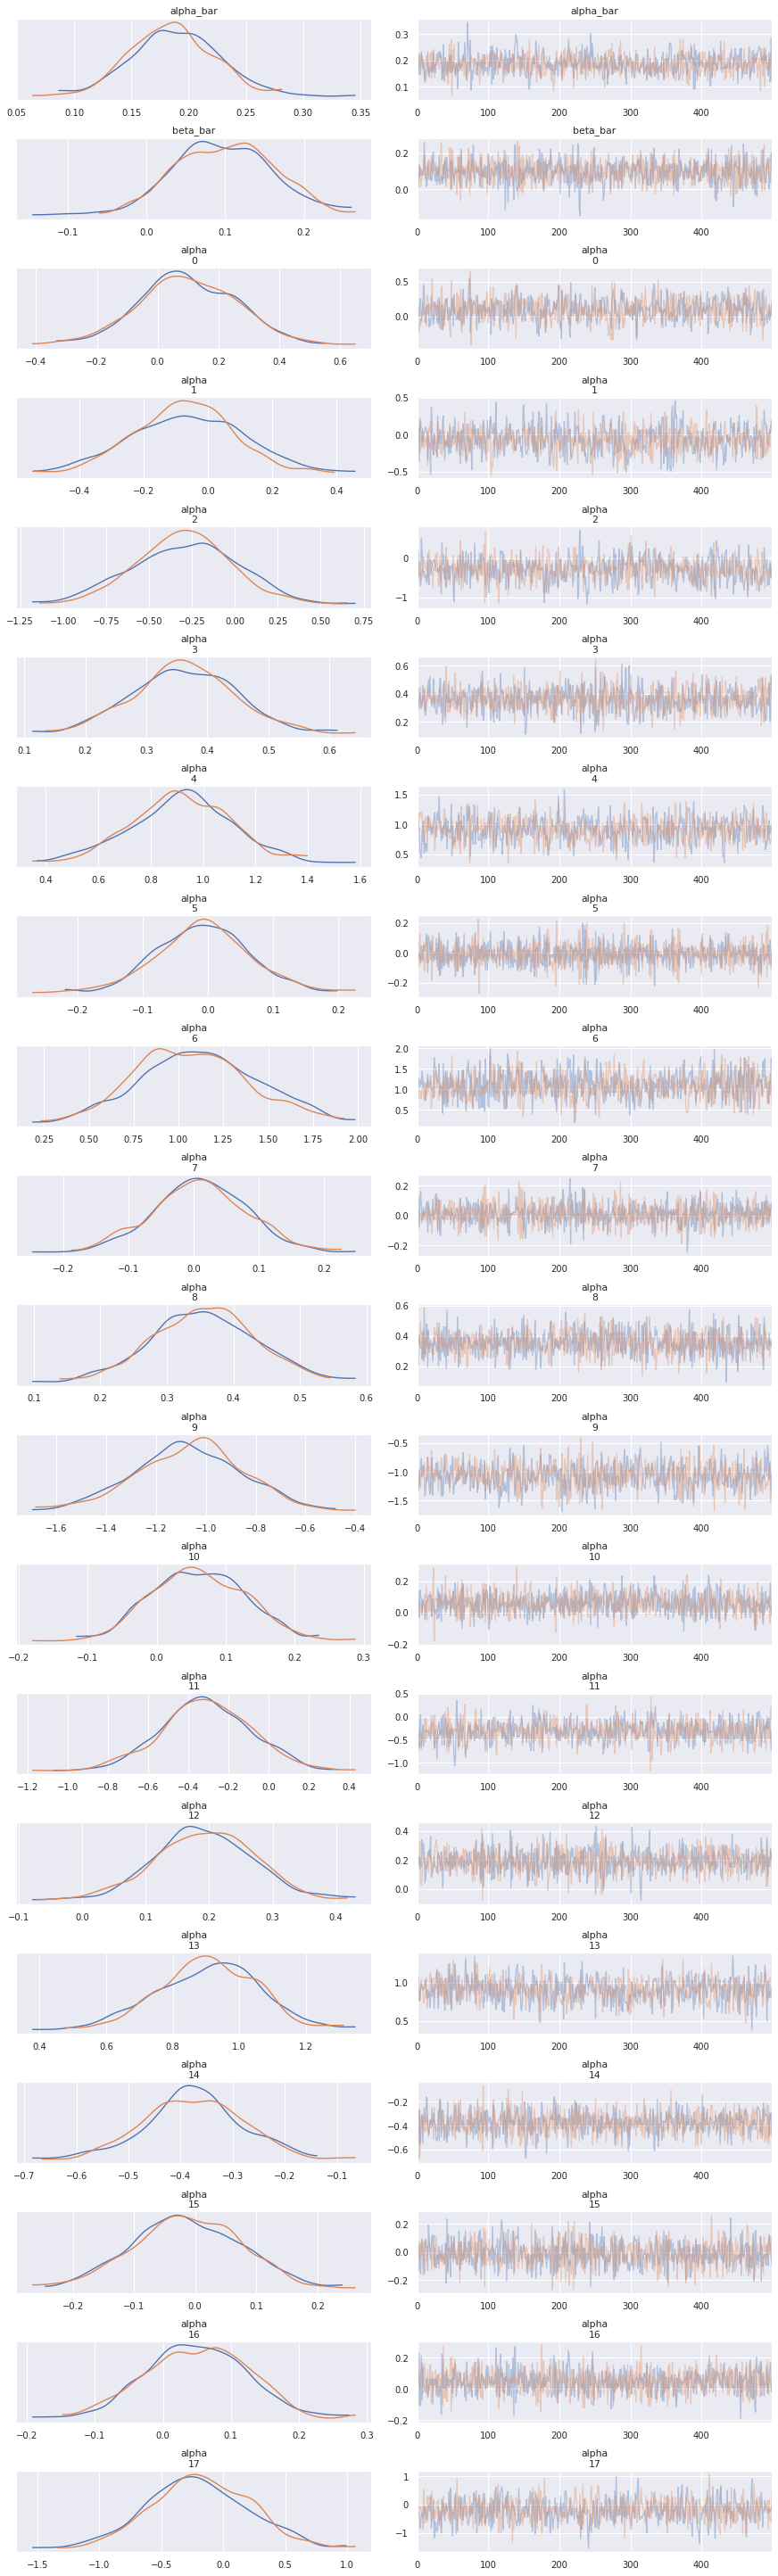

In [852]:
with model:
    az.plot_trace(trace)

In [853]:
result.describe()

,alpha_bar,beta_bar,alpha__0,alpha__1,alpha__2,alpha__3,alpha__4,alpha__5,alpha__6,alpha__7,...,beta__145,beta__146,beta__147,beta__148,beta__149,beta__150,beta__151,obs_sigma,alpha_sd,beta_sd
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.186489,0.097790,0.097457,-0.070036,-0.297248,0.360860,0.915125,-0.008501,1.093001,0.008923,...,0.026511,0.777509,-0.992659,0.207848,-0.378373,0.394419,0.753465,0.926797,0.431790,0.717235
std,0.037016,0.062597,0.159930,0.171297,0.291594,0.084061,0.191669,0.071891,0.316454,0.071023,...,0.086142,0.138275,0.148951,0.144216,0.225146,0.227680,0.321653,0.004707,0.040304,0.051573
min,0.063869,-0.145052,-0.410914,-0.545662,-1.177345,0.113729,0.349807,-0.269167,0.186741,-0.247374,...,-0.240219,0.360070,-1.497205,-0.215144,-1.095862,-0.498960,-0.342418,0.911004,0.322387,0.567154
25%,0.162138,0.055100,-0.005017,-0.187234,-0.491723,0.306682,0.791222,-0.054566,0.865909,-0.037041,...,-0.032244,0.685538,-1.092995,0.110115,-0.532120,0.239455,0.529530,0.923707,0.403579,0.682636
50%,0.185767,0.096585,0.089300,-0.070924,-0.294318,0.360442,0.917388,-0.008263,1.081485,0.008804,...,0.028918,0.782984,-0.986671,0.206187,-0.376254,0.399501,0.747147,0.926896,0.430402,0.717474
75%,0.210544,0.139519,0.211267,0.043260,-0.106279,0.417258,1.045814,0.037374,1.299415,0.055506,...,0.084488,0.864109,-0.889206,0.303255,-0.236698,0.541183,0.958683,0.929742,0.455954,0.748975
max,0.345344,0.265329,0.648983,0.459010,0.700555,0.641940,1.579892,0.225438,1.985533,0.247897,...,0.283840,1.227112,-0.507872,0.654392,0.380834,1.013028,1.892731,0.941191,0.598118,0.942048


In [854]:
def param_type(colName):
    if 'bar' in colName :
        return colName
    
    elif 'sd' in colName:
        return colName
    
    elif 'beta' in colName :
        return 'beta'
    elif 'alpha' in colName:
        return 'alpha'
    else:
        return colName
    
grp = result.groupby(param_type,axis=1)

alphas = grp.get_group('alpha')
betas = grp.get_group('beta')
obs_sigma = grp.get_group('obs_sigma')
alpha_bar = grp.get_group('alpha_bar')
alpha_sd = grp.get_group('alpha_sd')
beta_bar = grp.get_group('beta_bar')
beta_sd = grp.get_group('beta_sd')


In [855]:
alphas

,alpha__0,alpha__1,alpha__2,alpha__3,alpha__4,alpha__5,alpha__6,alpha__7,alpha__8,alpha__9,...,alpha__142,alpha__143,alpha__144,alpha__145,alpha__146,alpha__147,alpha__148,alpha__149,alpha__150,alpha__151
0,0.116961,-0.163732,-0.170599,0.274223,0.806667,-0.036985,1.112178,0.096121,0.494155,-1.174853,...,0.899224,1.135934,0.085411,0.038181,0.021840,0.586541,0.304072,0.595261,0.589541,0.042440
1,0.096744,-0.030476,-0.436531,0.437784,1.102135,0.007847,0.776605,-0.123981,0.361960,-0.787133,...,1.164672,0.431060,-0.006818,0.029974,-0.193808,0.644112,-0.053053,0.023763,0.052863,-0.558290
2,0.141567,0.083636,0.158774,0.361356,0.883921,-0.037483,1.287304,0.126101,0.356626,-1.326919,...,0.425743,0.924666,0.081007,0.051550,0.033571,0.691203,0.461204,0.403494,0.428151,-0.268930
3,0.002879,-0.365617,-0.440479,0.291682,0.942959,-0.002532,1.138419,-0.081799,0.403916,-1.284853,...,1.172639,0.709189,0.008258,-0.018622,-0.187534,0.698001,0.056713,0.109957,0.246766,-0.576381
4,0.255683,0.122942,-0.396723,0.407171,0.558794,-0.021158,1.065419,0.088557,0.335423,-0.979675,...,1.031167,0.567496,0.071920,0.114742,0.040733,0.464229,0.381382,0.200535,0.611311,-0.346468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.051411,0.025557,-0.512976,0.320872,0.854249,0.001792,0.658809,-0.055853,0.381754,-0.895706,...,0.789642,0.539525,-0.028723,0.102165,-0.048867,0.529970,0.223812,0.492047,0.387166,-0.273258
996,0.146757,-0.167362,-0.483401,0.397419,0.677368,-0.031008,1.367626,0.074632,0.265843,-1.029904,...,0.555836,0.873873,0.112767,-0.066938,-0.094692,0.623138,0.258369,0.026943,0.312056,-0.311655
997,-0.003897,0.114489,-0.076118,0.472004,0.687205,-0.070691,1.179570,-0.002303,0.370991,-1.540746,...,0.690640,0.779298,-0.007636,0.002286,-0.037988,0.629018,0.447414,0.387339,0.264404,-0.733752
998,0.032263,0.130328,-0.268728,0.518744,0.763856,-0.106187,1.135277,-0.026410,0.374379,-1.360286,...,0.621895,0.771123,-0.016397,0.045752,-0.068382,0.609701,0.392169,0.334396,0.152799,-0.838656


In [856]:
nr_rows = 500
nr_x = 100

rows = np.random.choice(range(len(alphas)),replace=True,size=nr_rows)

X = np.linspace(-2,2,nr_x)

alpha_samples = alphas.iloc[rows]
beta_samples = betas.iloc[rows]

lines = np.array([X[i] * beta_samples for i in range(len(X))])

lines = lines + alpha_samples.values
#lines[:,:,country_idx_map['SWE']]
lines[:,:,0]

array([[-0.39529016, -0.26332213,  0.03385512, ..., -0.53567327,
        -0.02739471,  0.13995774],
       [-0.38366433, -0.25412097,  0.03702924, ..., -0.51876367,
        -0.02589095,  0.13560028],
       [-0.3720385 , -0.24491981,  0.04020336, ..., -0.50185406,
        -0.02438718,  0.13124282],
       ...,
       [ 0.73241538,  0.62919028,  0.34174477, ...,  1.10455831,
         0.11847079, -0.28271556],
       [ 0.74404121,  0.63839144,  0.34491889, ...,  1.12146791,
         0.11997456, -0.28707301],
       [ 0.75566705,  0.6475926 ,  0.34809301, ...,  1.13837752,
         0.12147833, -0.29143047]])

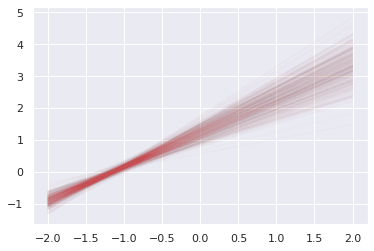

In [857]:
_= plt.plot(X,lines[:,:,country_idx_map['SWE']],color='r',alpha=0.01)

In [858]:
mean_betas = betas.mean()
mean_betas.index = list(country_idx_map.keys())
mean_betas.loc['SWE']

1.0721322431747728

In [859]:
mean_alphas = alphas.mean()
mean_alphas.index = list(country_idx_map.keys())
mean_alphas.loc['SWE']

1.2309635243513124

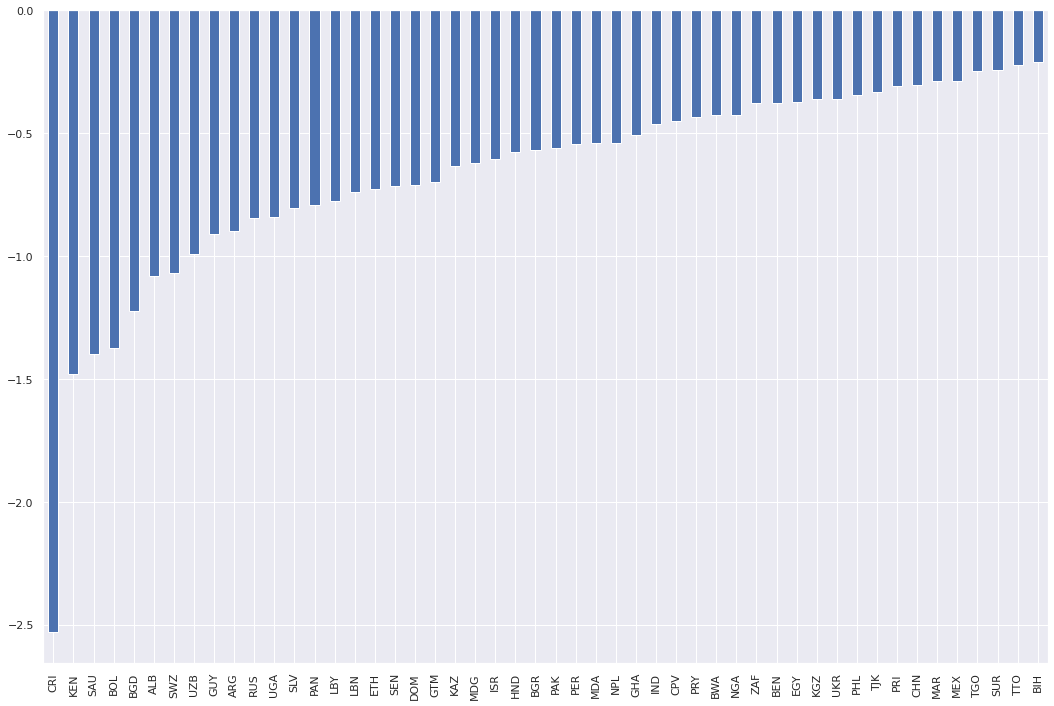

In [860]:
mean_betas.sort_values()[:50].plot(kind='bar',figsize=(18,12))
plt.savefig('ox_hierarchical_0_50_shift_{}.jpg'.format(shift),format='jpg')

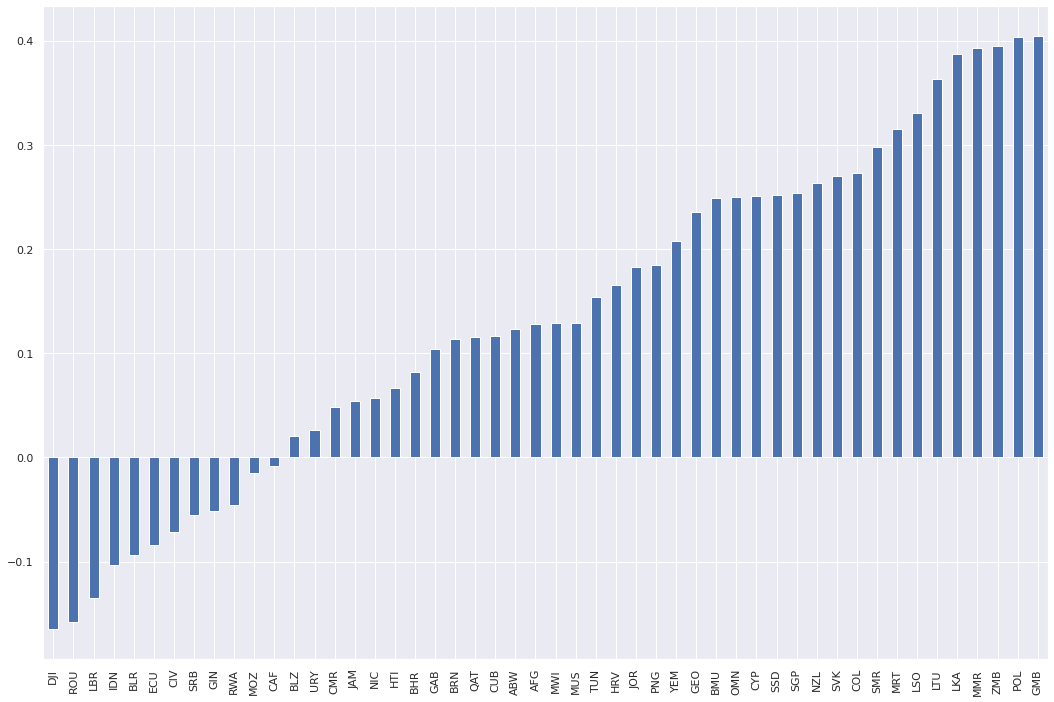

In [861]:
mean_betas.sort_values()[50:100].plot(kind='bar',figsize=(18,12))
plt.savefig('ox_hierarchical_50__100_shift_{}.jpg'.format(shift),format='jpg')

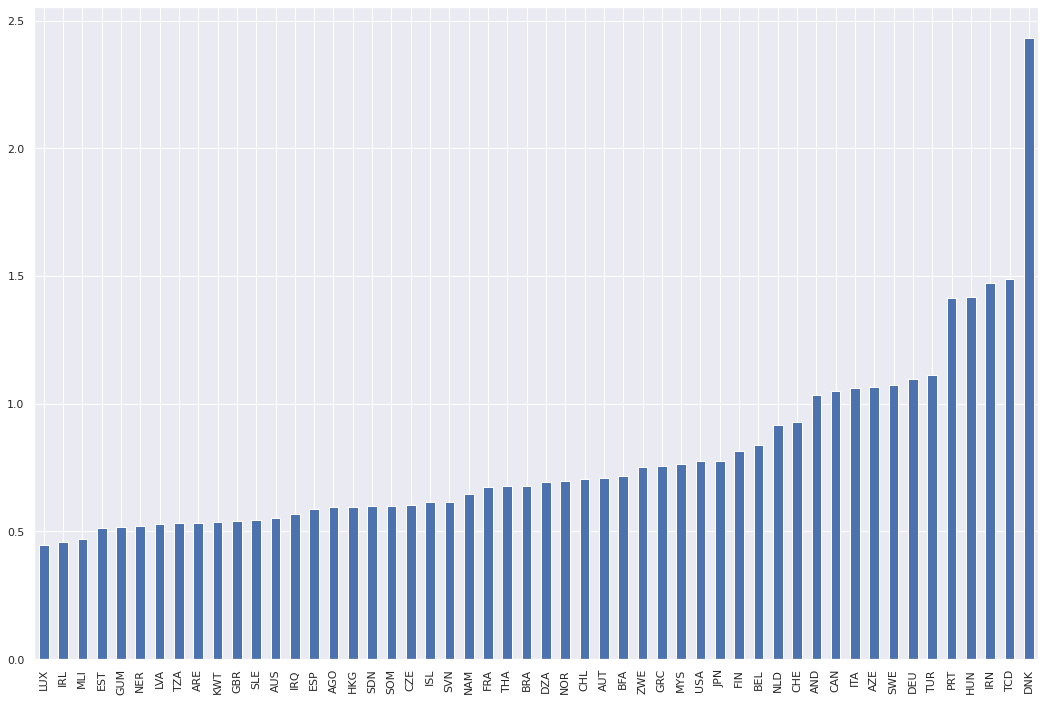

In [862]:
mean_betas.sort_values()[100:].plot(kind='bar',figsize=(18,12))
plt.savefig('ox_hierarchical_100_shift_{}.jpg'.format(shift),format='jpg')

/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/site-packages/a

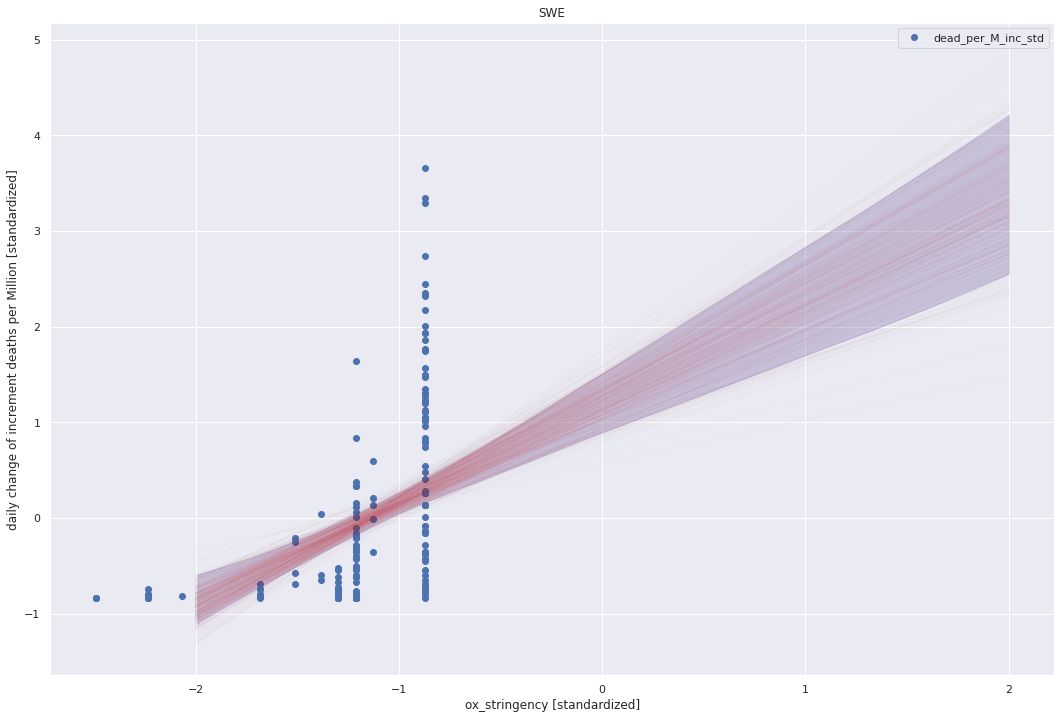

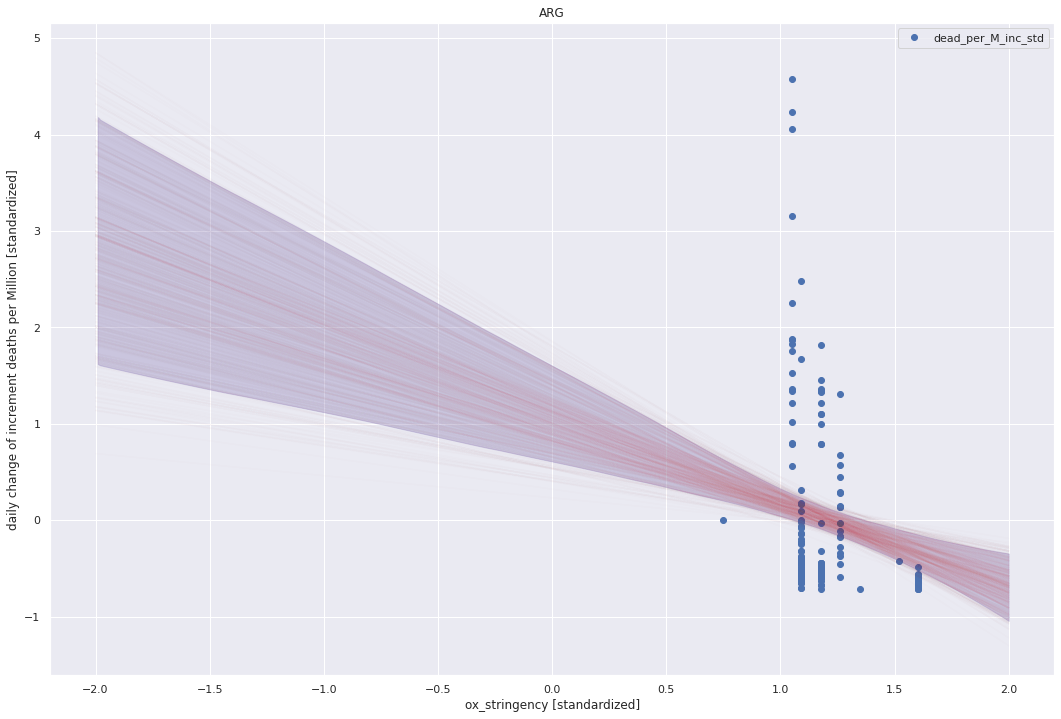

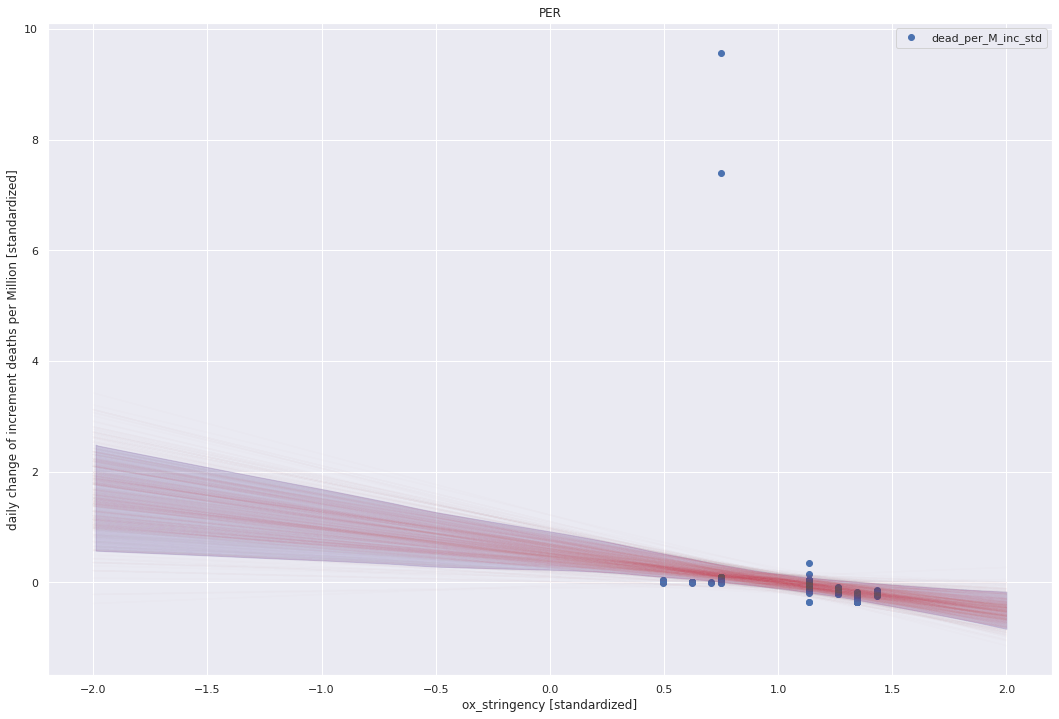

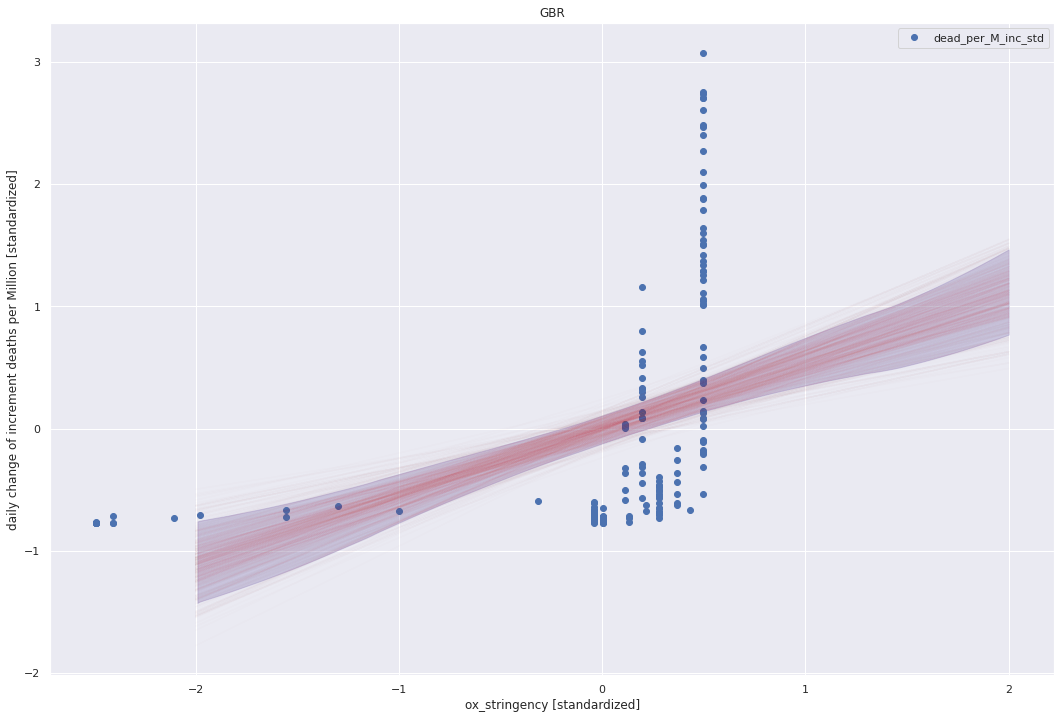

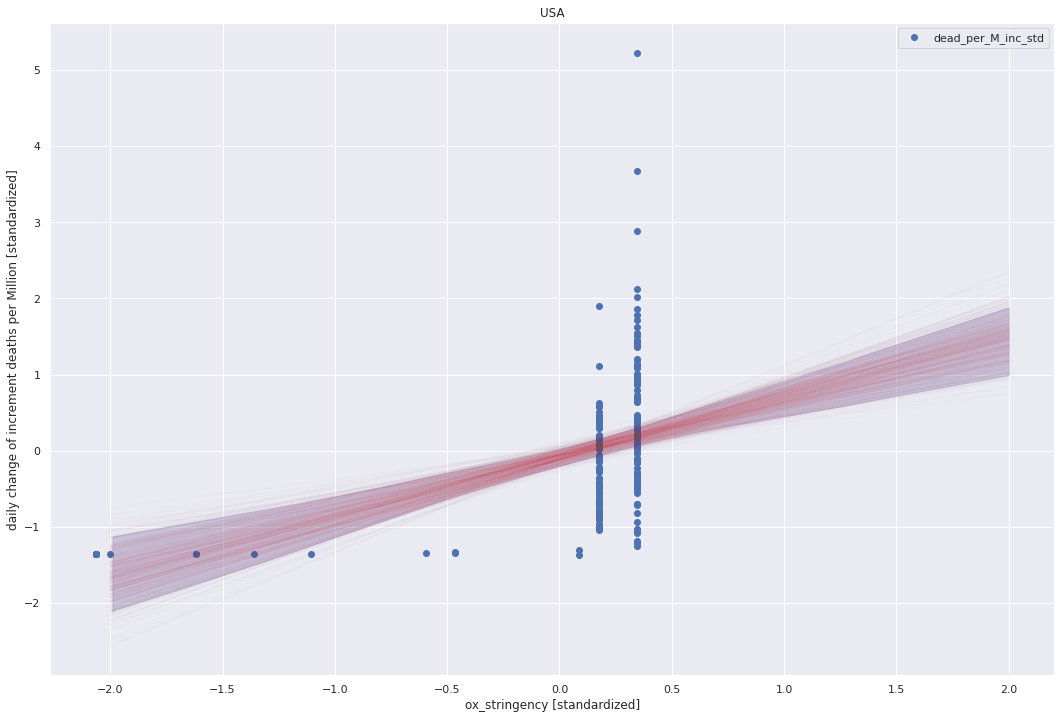

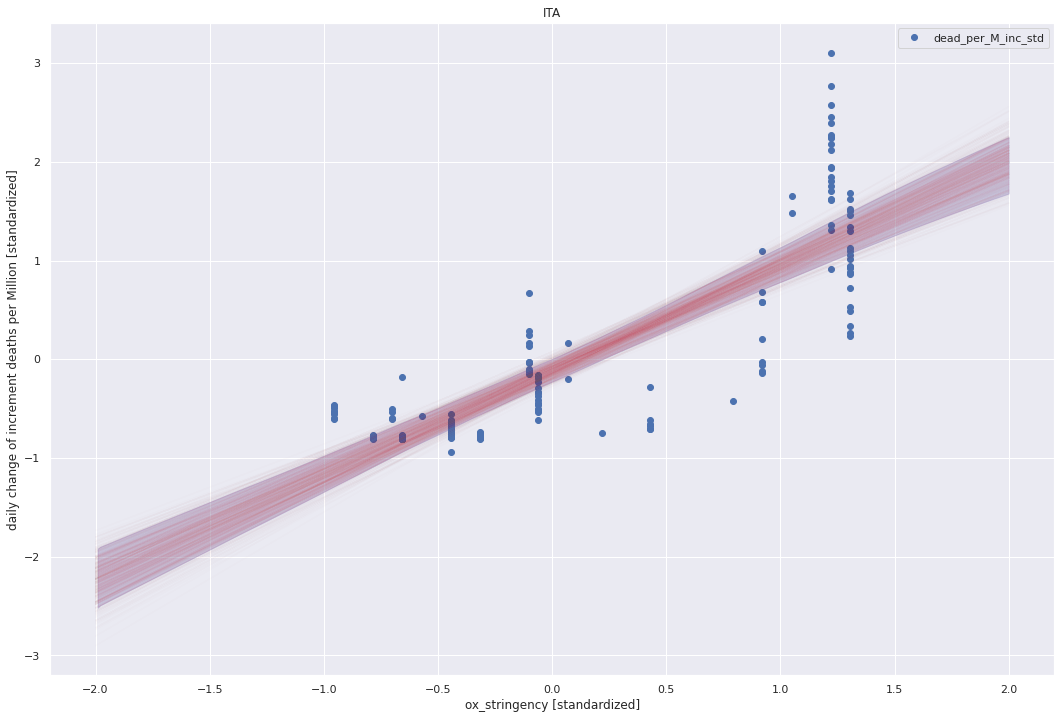

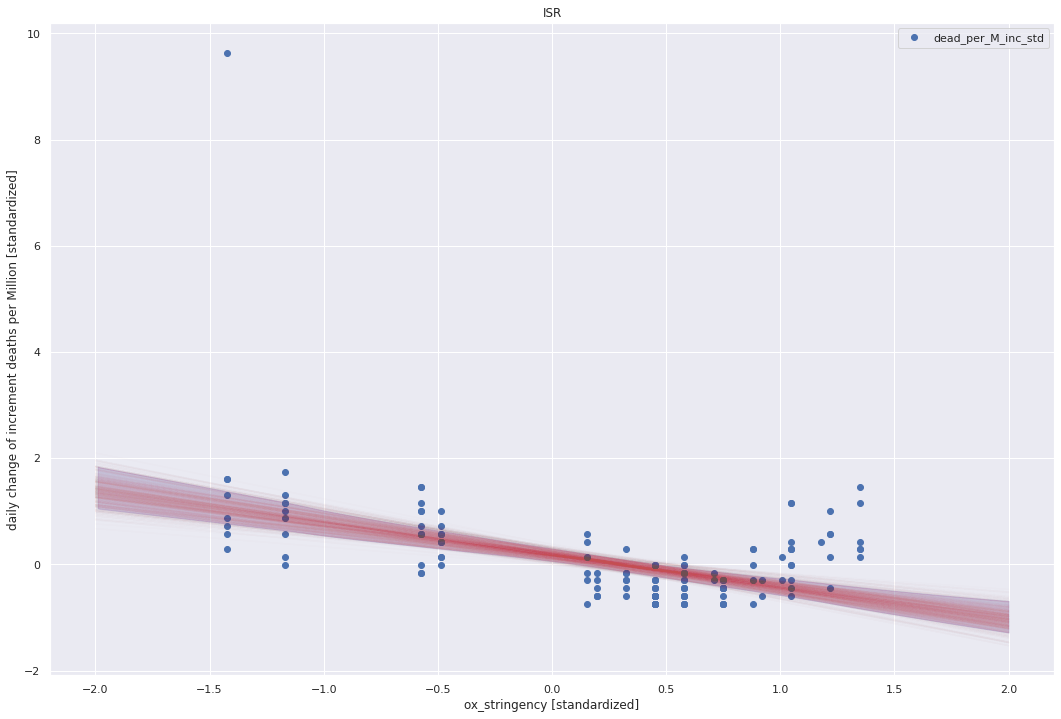

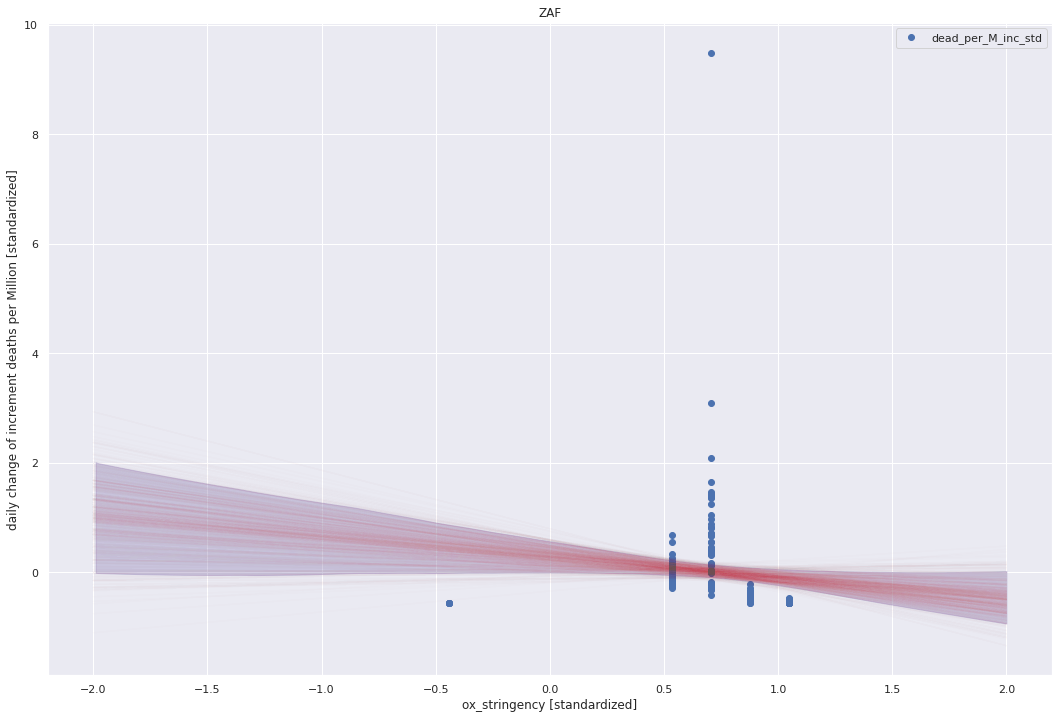

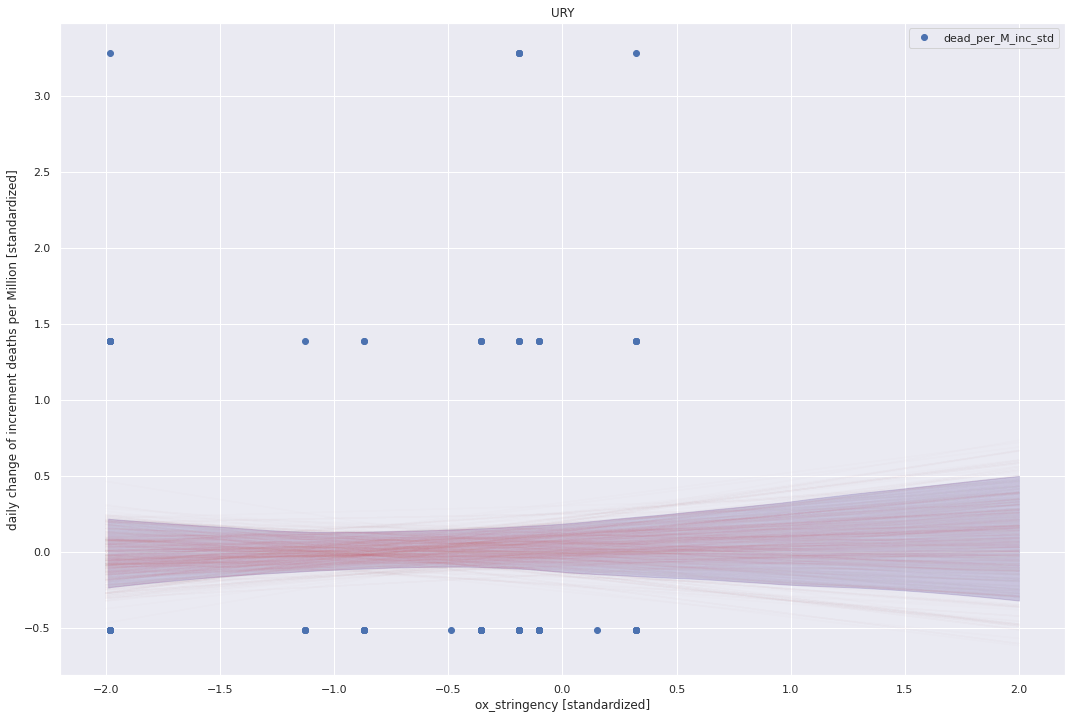

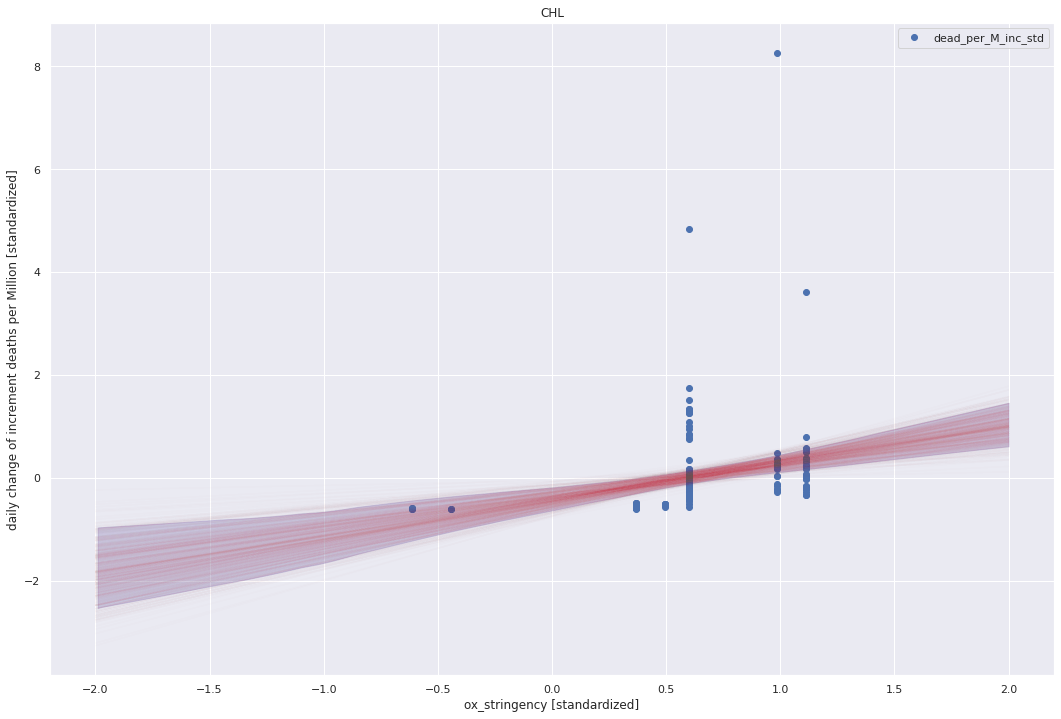

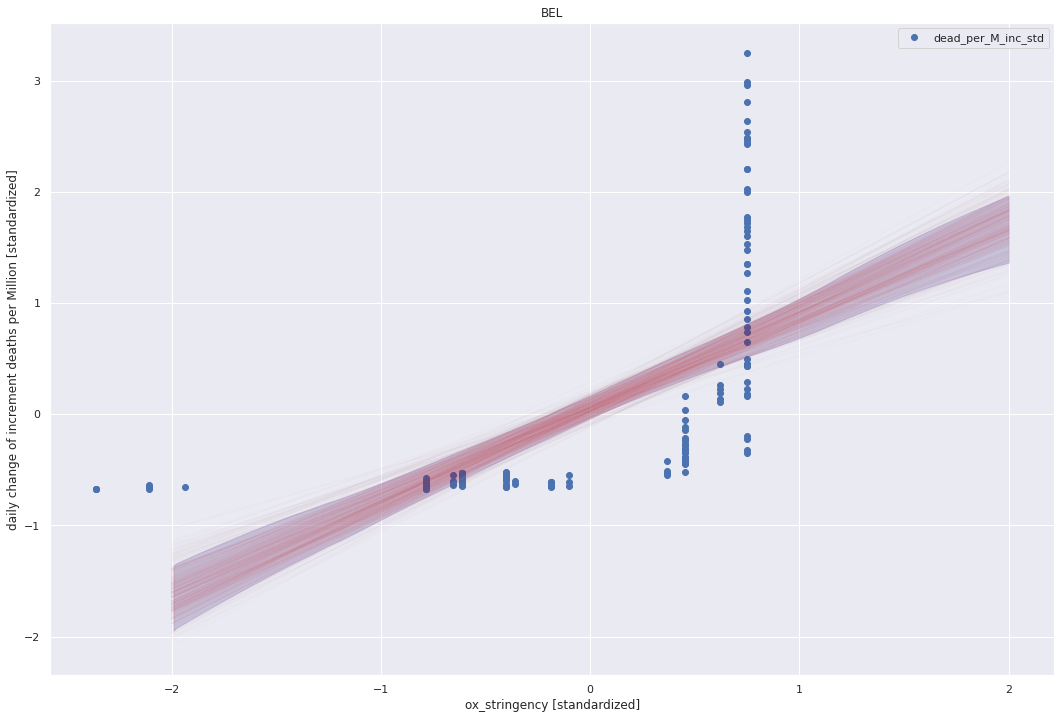

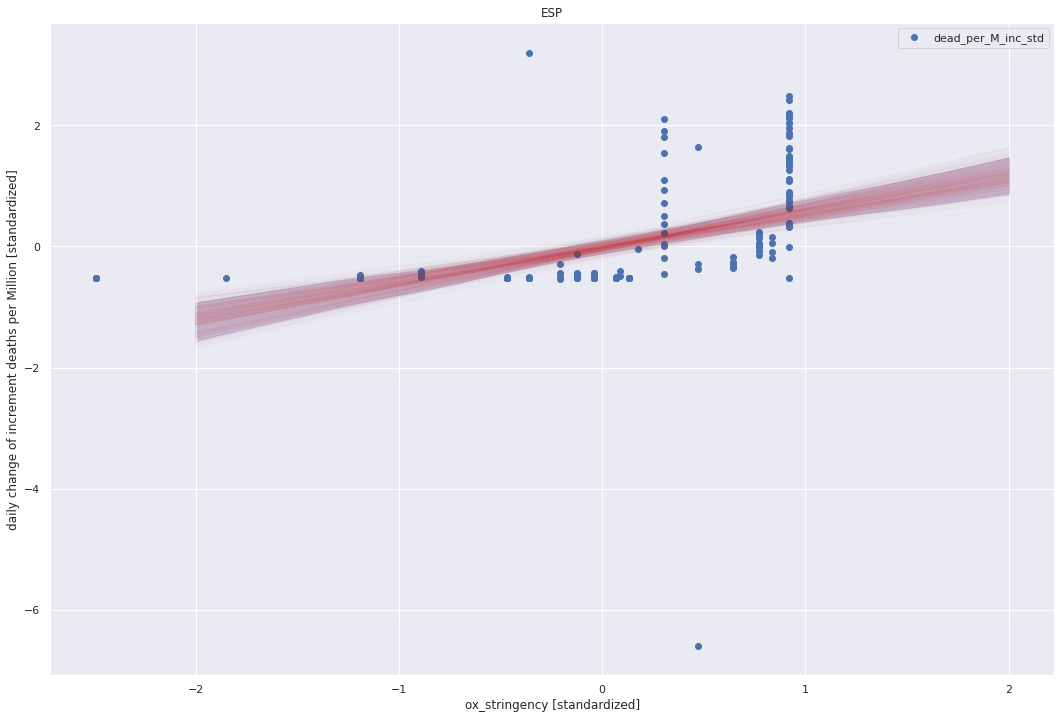

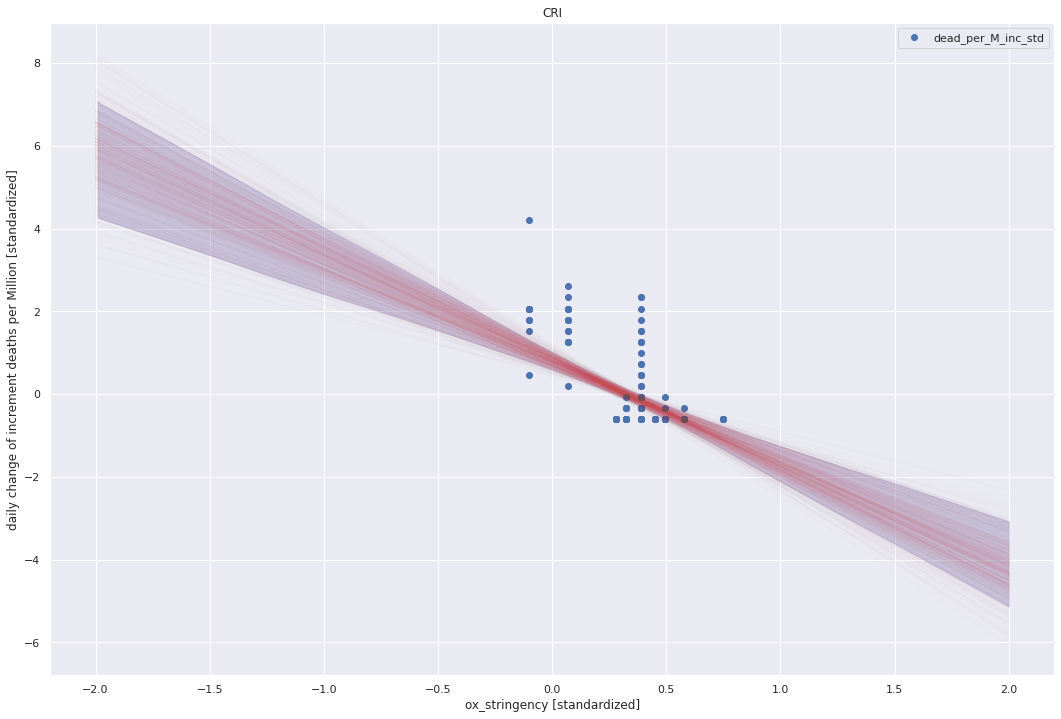

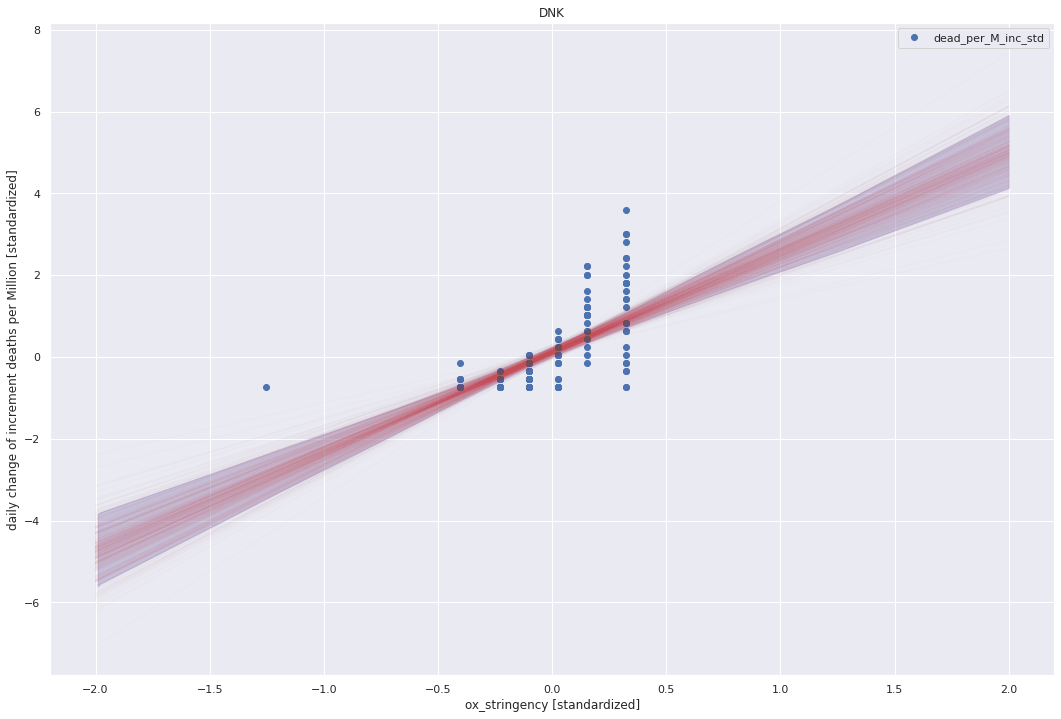

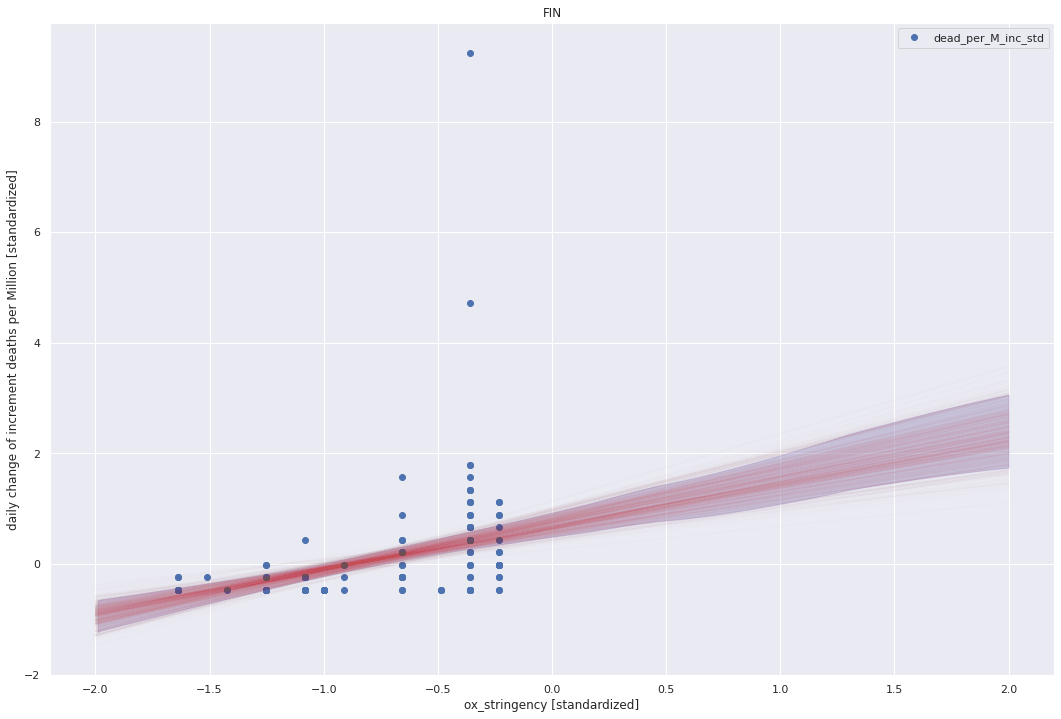

In [871]:
def plot_reg(country_abb):
    fill_kwargs = {'alpha': 0.3}

    country = all_shifted.loc[all_shifted['abb'] == country_abb]
    
    #X = np.linspace(country['ox_std'].min(),country['ox_std'].max(),100)
    
    ax= country.plot(x='ox_std',y='dead_per_M_inc_std',style='o',figsize=(18,12),
                    title=country_abb.upper())
    
    ax.plot(X,lines[:,:,country_idx_map[country_abb]],color='r',alpha=0.01)
    
    
    az.plot_hdi(X,lines[:,:,country_idx_map[country_abb]].T,ax=ax,hdi_prob=0.89,
               fill_kwargs=fill_kwargs,color='m')
    
    plt.xlabel('ox_stringency [standardized]')
    plt.ylabel('daily change of increment deaths per Million [standardized]')
    plt.savefig('ox_hierarchical_reg_{}_shift_{}.jpg'.format(country_abb,shift),format='jpg')

country_abbs = ['SWE','ARG','PER','GBR','USA','ITA','ISR','ZAF','URY','CHL','BEL','ESP','CRI','DNK','FIN']

for c in country_abbs:
    plot_reg(c)


In [864]:
betas.columns = list(country_idx_map.keys())
alphas.columns = list(country_idx_map.keys())

beta_CIs = betas.quantile([0.055,0.945])
alpha_CIs = alphas.quantile([0.055,0.945])

beta_means = betas.mean()
alpha_means = alphas.mean()
alpha_CIs.loc[0.055,'SWE']

0.8889741912550324

In [865]:
ca = 'SWE'
alpha_CIs.loc[0.055,ca]

0.8889741912550324

/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/site-packages/a

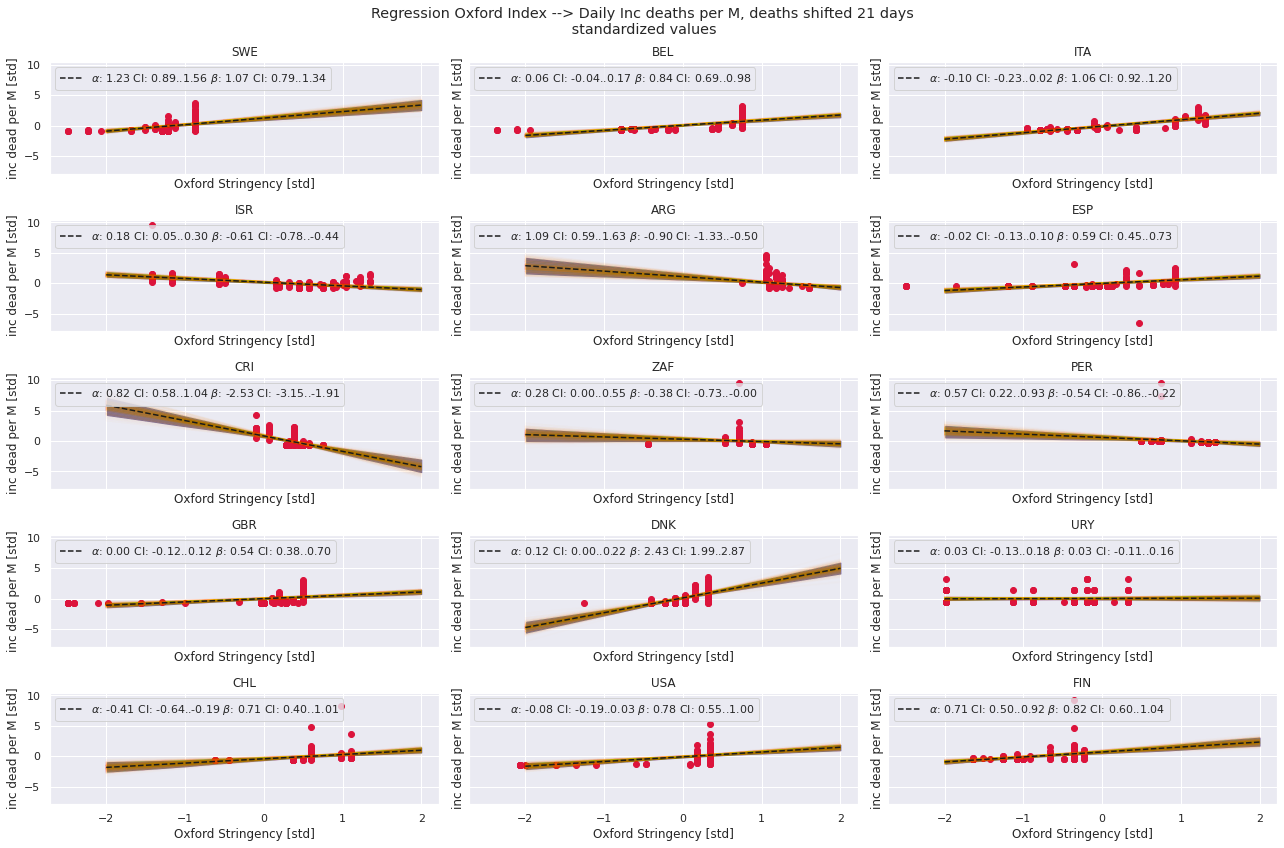

In [876]:
r,c = 5,3 #rows,cols

fill_kwargs = {'alpha': 1}


fig,axes = plt.subplots(r,c,sharex=True,sharey=True,figsize=(18,12))

for i,ca in enumerate(country_abbs):
    
    country = all_shifted.loc[all_shifted['abb'] == ca]
    
    label = r'$\alpha$: {:.2f} CI: {:.2f}..{:.2f} $\beta$: {:.2f} CI: {:.2f}..{:.2f}'.format(
    alpha_means[ca],alpha_CIs.loc[0.055,ca],alpha_CIs.loc[0.945,ca],
    beta_means[ca],beta_CIs.loc[0.055,ca],beta_CIs.loc[0.945,ca])

    axes[i % r,i % c].plot(country['ox_std'],country['dead_per_M_inc_std'],'o',color='crimson')
    
    #X = np.linspace(country['ox_std'].min(),country['ox_std'].max(),nr_x)
    X = np.linspace(-2,2,nr_x)
    
    axes[i % r,i % c].plot(X,lines[:,:,country_idx_map[ca]],color='orange',alpha=0.01)
    
    axes[i % r, i % c].plot(X,alpha_means[ca] + X * beta_means[ca],color='k',
                            ls='dashed',label=label)
    
    axes[i % r,i % c].set_title(ca)
    axes[i % r, i % c].set_ylabel('inc dead per M [std]')
    axes[i % r, i % c].set_xlabel('Oxford Stringency [std]')
    axes[i % r, i % c].legend(loc='upper left')
    
    az.plot_hpd(X, lines[:,:,country_idx_map[ca]].T,ax=axes[i % r,i % c],
                color='m',fill_kwargs=fill_kwargs,hdi_prob=0.89)
    
    
fig.suptitle('Regression Oxford Index --> Daily Inc deaths per M, deaths shifted {} days\n standardized values'.format(shift))
    
plt.tight_layout()
plt.savefig('ox_hierarchical_multi_shifted_{}.jpg'.format(shift),format='jpg')

In [867]:
all_shifted.loc[all_shifted['abb'] == 'CRI']

,date,confirmed,dead,oxford_stringency,country,pop,dead_per_M,abb,dead_per_M_std,ox_std,dead_inc,dead_per_M_inc,dead_per_M_inc_std,dead_per_M_change,dead_per_M_change_std,country_idx
4529,2020-03-23,134.0,2.0,71.30,Costa Rica,5094118,0.392610,CRI,-0.373738,0.281208,0.0,0.000000,-0.594170,0.000000e+00,-0.025408,33
4530,2020-03-24,158.0,2.0,71.30,Costa Rica,5094118,0.392610,CRI,-0.373738,0.281208,0.0,0.000000,-0.594170,0.000000e+00,-0.025408,33
4531,2020-03-25,177.0,2.0,71.30,Costa Rica,5094118,0.392610,CRI,-0.373738,0.281208,0.0,0.000000,-0.594170,0.000000e+00,-0.025408,33
4532,2020-03-26,201.0,2.0,71.30,Costa Rica,5094118,0.392610,CRI,-0.373738,0.281208,0.0,0.000000,-0.594170,0.000000e+00,-0.025408,33
4533,2020-03-27,231.0,2.0,71.30,Costa Rica,5094118,0.392610,CRI,-0.373738,0.281208,0.0,0.000000,-0.594170,0.000000e+00,-0.025408,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4678,2020-08-19,29643.0,314.0,66.67,Costa Rica,5094118,61.639719,CRI,0.038060,0.067921,10.0,1.963048,2.067576,-7.105427e-15,-0.025408,33
4679,2020-08-20,30409.0,321.0,66.67,Costa Rica,5094118,63.013852,CRI,0.047299,0.067921,7.0,1.374134,1.269052,-5.889145e-01,-1.492705,33
4680,2020-08-21,31075.0,333.0,66.67,Costa Rica,5094118,65.369510,CRI,0.063138,0.067921,12.0,2.355658,2.599925,9.815242e-01,2.420087,33
4681,2020-08-22,32134.0,340.0,66.67,Costa Rica,5094118,66.743644,CRI,0.072377,0.067921,7.0,1.374134,1.269052,-9.815242e-01,-2.470903,33


<AxesSubplot:ylabel='Frequency'>

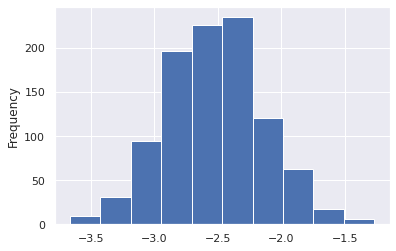

In [868]:
betas['CRI'].plot(kind='hist')